In [ ]:
#!pip install umap-learn
#!pip install yellowbrick
#!pip install pyLDAvis
#!pip install gensim

In [64]:
import pandas as pd
import pickle
from nltk.corpus import stopwords
import os

# visualization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans 

# Probabilistic Modeling
from sklearn.decomposition import LatentDirichletAllocation
import gensim
from gensim import matutils, models
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import scipy.sparse

import umap.umap_ as umap
from yellowbrick.text import UMAPVisualizer

import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.sklearn

import matplotlib.pyplot as plt

## Helper Functions

In [2]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '", topic_names[ix], "'")
        print(", ".join([feature_names[i]
                         for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [55]:
def get_nmf_topics(model, n_top_words):
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = cv.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [6]:
df = pd.read_csv(f'tweets/tweets_processed/coronavirus_california_tweets_processed', engine = 'python')

In [7]:
df['processed_text'] = df['processed_text'].values.astype(str)

## Vectorizer

In [79]:
cities = pickle.load(open('tweets/cities_list.txt', 'rb'))

In [29]:
stop_words = stopwords.words('english')
stop_words.extend(['coronavirus', 'covid', 'covidー', 'coronavirusoutbreak', 'coronaviruspandemic'])
stop_words.extend(list(cities['california']))
stop_words.extend(['california'])
stop_words = set(stop_words)

In [49]:
num_topics = 6
index_names = [f'component_{x}' for x in range(num_topics)]
random_state = 42
n_gram = (1,2)
min_df = 3
max_df = 0.85

In [50]:
cv = CountVectorizer(analyzer='word',
                     min_df=min_df,
                     max_df=max_df,
                     ngram_range = n_gram,
                     stop_words=stop_words,
                     lowercase=True,
                     token_pattern='[a-zA-Z0-9]{3,}',
                     max_features=5000,
                     )
data_dtm = cv.fit_transform(df['processed_text'])

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acres', 'afb', 'agoura', 'air', 'alamitos', 'alamos', 'aliso', 'almaden', 'alto', 'altos', 'amador', 'american', 'ana', 'andreas', 'angeles', 'angels', 'angelus', 'anselmo', 'apple', 'ardo', 'arena', 'arrowhead', 'arroyo', 'aukum', 'avila', 'baldwin', 'baldy', 'banos', 'bar', 'barbara', 'barn', 'base', 'bass', 'bautista', 'bay', 'beach', 'beale', 'bear', 'bella', 'belvedere', 'ben', 'bend', 'bernardino', 'berry', 'bethel', 'beverly', 'bidwell', 'big', 'birds', 'blairsden', 'blue', 'bluff', 'borrego', 'boulder', 'boyes', 'bragg', 'bridges', 'browns', 'bruno', 'bryn', 'buena', 'burnt', 'butte', 'cajon', 'camp', 'canada', 'canoga', 'cantua', 'capistrano', 'cardiff', 'carlos', 'carnelian', 'castro', 'cathedral', 'catheys', 'cbc', 'cedar', 'cedarpines', 'cedro', 'center', 'centro', 'cerrito', 'ch

## NMF

In [45]:
# tf, dtm = createCustomTFIDFvectorizer(new_df, n_range=(1,2), stop = stop_words)

# don't use TF-IDF for tweets
# use CV because it's a small doc
# suggestion - binary = True ~ can throw in a lot of noise
# cv = CountVectorizer(ngram_range = n_gram, stop_words = stop_words, min_df=min_df, max_df=max_df)
# data_dtm = cv.fit_transform(new_df.full_text)

In [51]:
nmf_model = NMF(n_components = num_topics, random_state = random_state)
doc_topic_nmf = nmf_model.fit_transform(data_dtm)

topic_word_nmf = pd.DataFrame(nmf_model.components_.round(3),
                                  index=index_names,
                                  columns=cv.get_feature_names())

# doc_topic_nmf_chosen = performCustomNMF(tf, dtm, index_names = index_names)
#len(doc_topic_nmf_chosen)

In [62]:
kmeans = KMeans(n_clusters=num_topics, random_state=random_state).fit(doc_topic_nmf)
cluster_topic_nmf = kmeans.labels_

In [53]:
display_topics(nmf_model, cv.get_feature_names(), 60, topic_names=None)


Topic  0
amp, pandemic, time, help, get, need, day, health, new, like, one, business, news, know, crisis, make, take, outbreak, please, due, amid, week, today, work, public, going, worker, world, good, virus, say, care, thing, way, social, community, family, first, life, still, keep, see, could, would, quarantine, right, many, spread, free, may, test, read, everyone, let, want, response, food, county, update, support

Topic  1
trump, president, virus, say, response, american, chinese, donald, donald trump, president trump, china, pandemic, chinese virus, administration, briefing, reporter, trump administration, news, calling, drug, would, racist, press, crisis, call, white, trump say, house, lie, said, america, force, act, white house, conference, could, task, medium, stop, task force, hoax, calling chinese, claim, production, government, border, called, january, biden, know, want, president donald, knew, threat, handling, warned, attack, bill, week, defense

Topic  2
state, united, u

In [61]:
get_nmf_topics(nmf_model, 60)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06
0,amp,trump,state,via,home,people
1,pandemic,president,united,amid,stay,get
2,time,virus,united state,news,stay home,many
3,help,say,case,million,order,like
4,get,response,new,stock,spread,million
5,need,american,county,say,newsom,know
6,day,chinese,death,pandemic,home order,virus
7,health,donald,confirmed,outbreak,county,test
8,new,donald trump,test,live,gov,going
9,like,president trump,york,pandemic via,safe,need


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/opt/conda/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single 

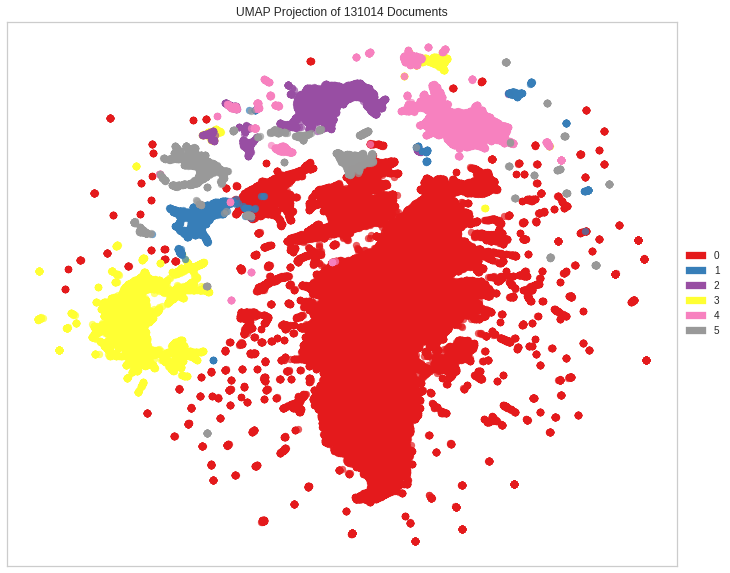

In [63]:
plt.figure(figsize=(15,10))
docs = doc_topic_nmf
labels = cluster_topic_nmf

umap = UMAPVisualizer(metric ='euclidean', colormap = 'Set1', random_state=42)
umap.fit(docs, labels)
umap.show()

## LDA
Topics generated from NMF are more coherent than LDA, so I've decided to use NMF.

In [58]:
# vectorizer = CountVectorizer(analyzer='word',
#                              min_df=min_df,
#                              max_df=max_df,
#                              stop_words=stop_words,
#                              lowercase=True,
#                              token_pattern='[a-zA-Z0-9]{3,}',
#                              max_features=5000,
#                              )

# data_vectorized = vectorizer.fit_transform(data_df['script'])
lda_model = LatentDirichletAllocation(n_components=num_topics,  # Number of topics
                                      learning_method='online',
                                      random_state=random_state,
                                      n_jobs=-1  # Use all available CPUs
                                      )
lda_output = lda_model.fit_transform(data_dtm)

display_topics(lda_model, cv.get_feature_names(), 40)


Topic  0
need, business, make, pandemic, help, life, see, trump, via, worker, amp, health, american, hour, care, store, open, million, sick, employee, read, time, risk, job, economy, must, mask, making, people, supply, money, leave, protect, small, please, get, still, essential, healthcare, sign

Topic  1
people, stay, virus, home, get, time, like, quarantine, one, world, china, amp, going, close, everyone, got, could, day, take, think, community, spread, trump, let, chinese, stay home, safe, stop, please, come, dont, much, getting, would, fight, back, give, via, medical, show

Topic  2
test, due, right, death, want, day, family, free, patient, service, italy, positive, via, question, today, share, los, angeles, los angeles, long, since, concern, symptom, call, infected, socialdistancing, outbreak, lockdown, emergency, time, test positive, others, testing, something, still, member, human, hospital, use, slow

Topic  3
trump, amid, pandemic, news, say, week, via, crisis, keep, presiden

In [59]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_dtm, cv, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
1       1.465019 -47.625065       1        1  22.190823
0      54.854797 -36.476795       2        1  17.233767
4      32.212929 -61.444572       3        1  17.077293
3       5.111096 -14.110332       4        1  15.956438
5      26.350170 -33.374702       5        1  15.872544
2      38.109818  -7.222781       6        1  11.669134, topic_info=           Term         Freq         Total Category  logprob  loglift
589        case  5554.000000   5554.000000  Default  30.0000  30.0000
2861       need  5303.000000   5303.000000  Default  29.0000  29.0000
2882        new  6950.000000   6950.000000  Default  28.0000  28.0000
4418       test  4152.000000   4152.000000  Default  27.0000  27.0000
1311        due  4070.000000   4070.000000  Default  26.0000  26.0000
...         ...          ...           ...      ...      ...      ...
2548   lockdown  1079.586332   1800.705949   Topic6  -4.9722   1.6366
1412  emergency  1043.694288   1732.744405   Topic6  -5.0060   1.6413
4748        via  1592.622887  11784.958439   Topic6  -4.5834   0.1468
3044   outbreak  1080.422897   4578.657541   Topic6  -4.9714   0.7042
4482       time  1032.897826   7241.966115   Topic6  -5.0164   0.2007

[299 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
120       3  0.999194        already
132       2  0.757693       american
132       5  0.242139       american
136       4  0.999904           amid
140       4  0.999442  amid outbreak
...     ...       ...            ...
4934      4  0.190898          world
4934      6  0.008300          world
4969      3  0.339856           year
4969      5  0.659869           year
4978      5  0.999494           york

[352 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 4, 6, 3])

In [76]:
state_list = ['california', 'colorado', 'florida',
              'georgia', 'idaho', 'illinois',
              'louisiana', 'massachusetts', 'newyork',
              'tennessee', 'texas', 'washington']

for state in state_list:
    if not os.path.exists(f'tweets/models/{state}'):
        os.makedirs(f'tweets/models/{state}')

In [101]:
def generateModel(state, remove_common=False):
    df = pd.read_csv(f'tweets/tweets_processed/coronavirus_{state}_tweets_processed', engine = 'python')
    df['processed_text'] = df['processed_text'].values.astype(str)
    
    
    stop_words = stopwords.words('english')
    stop_words.extend(['coronavirus', 'covid', 'covidー', 'coronavirusoutbreak', 'coronaviruspandemic'])
    stop_words.extend(list(cities[state]))
    stop_words.extend([state])
    
    if remove_common:
        stop_words.extend(['say', 'pandemic', 'test', 'outbreak', 'health', 'news', 'spread', 'crisis',
                         'virus', 'response', 'china', 'positive', 'day', 'business', 'due', 'week',
                         'update', 'million', 'live', 'time', 'new', 'testing', 'first', 'american',
                         'briefing', 'could', 'need', 'one', 'know', 'death', 'help', 'like', 'amid',
                         'would', 'make', 'work', 'public', 'world', 'official', 'stay', 'get', 'take',
                         'state', 'report', 'case', 'home', 'amp', 'please', 'worker', 'trump',
                         'chinese', 'number', 'stock', 'order', 'tested', 'going', 'still', 'drug',
                         'said', 'senator', 'many', 'thing', 'social', 'president', 'medium',
                         'confirmed', 'new case', 'confirmed case', 'italy', 'via', 'today', 'life',
                         'donald', 'donald trump', 'president trump', 'united', 'united state',
                         'county', 'new york', 'total', 'people', 'right', 'department', 'care', 'way',
                         'family', 'press', 'call', 'house', 'stop', 'york', 'reported',
                         'test positive', 'keep', 'administration', 'reporter', 'hospital', 'travel',
                         'adult', 'dumped', 'stay home', 'governor', 'think', 'emergency', 'across',
                         'tested positive', 'act', 'country', 'pandemic via', 'nyt', 'want', 'latest',
                         'government', 'good', 'chinese virus', 'trump administration', 'white', 'two',
                         'via nyt', 'million stock', 'doctor', 'dont', 'action', 'cdc', 'community',
                         'force', 'dumped million', 'sen', 'younger', 'march', 'sign', 'close',
                         'breaking', 'case death', 'state department', 'see', 'white house',
                         'crisis via', 'safe', 'patient', 'hospitalization', 'bill'])
    stop_words = set(stop_words)
    
    num_topics = 6
    index_names = [f'component_{x}' for x in range(num_topics)]
    random_state = 42
    n_gram = (1,2)
    min_df = 3
    max_df = 0.85
    
    n_top_words = 40
    
    cv = CountVectorizer(analyzer='word',
                     min_df=min_df,
                     max_df=max_df,
                     ngram_range = n_gram,
                     stop_words=stop_words,
                     lowercase=True,
                     token_pattern='[a-zA-Z0-9]{3,}',
                     max_features=5000,
                     )
    data_dtm = cv.fit_transform(df['processed_text'])
    
    nmf_model = NMF(n_components = num_topics, random_state = random_state)
    doc_topic_nmf = nmf_model.fit_transform(data_dtm)

    topic_word_nmf = pd.DataFrame(nmf_model.components_.round(3),
                                      index=index_names,
                                      columns=cv.get_feature_names())

    feat_names = cv.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = nmf_model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict[f'topic{i}'] = words;
    if remove_common:
        pickle.dump(word_dict, open(f'tweets/models/{state}/{state}_specific_topics.txt', 'wb'))
        pickle.dump(nmf_model, open(f'tweets/models/{state}/{state}_specific_model.pkl', 'wb'))
    else:
        pickle.dump(word_dict, open(f'tweets/models/{state}/{state}_common_topics.txt', 'wb'))
        pickle.dump(nmf_model, open(f'tweets/models/{state}/{state}_common_model.pkl', 'wb'))
    print(f'{state} successfully dumped models and topics')

In [80]:
for state in state_list:
    generateModel(state)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acres', 'afb', 'agoura', 'air', 'alamitos', 'alamos', 'aliso', 'almaden', 'alto', 'altos', 'amador', 'american', 'ana', 'andreas', 'angeles', 'angels', 'angelus', 'anselmo', 'apple', 'ardo', 'arena', 'arrowhead', 'arroyo', 'aukum', 'avila', 'baldwin', 'baldy', 'banos', 'bar', 'barbara', 'barn', 'base', 'bass', 'bautista', 'bay', 'beach', 'beale', 'bear', 'bella', 'belvedere', 'ben', 'bend', 'bernardino', 'berry', 'bethel', 'beverly', 'bidwell', 'big', 'birds', 'blairsden', 'blue', 'bluff', 'borrego', 'boulder', 'boyes', 'bragg', 'bridges', 'browns', 'bruno', 'bryn', 'buena', 'burnt', 'butte', 'cajon', 'camp', 'canada', 'canoga', 'cantua', 'capistrano', 'cardiff', 'carlos', 'carnelian', 'castro', 'cathedral', 'catheys', 'cbc', 'cedar', 'cedarpines', 'cedro', 'center', 'centro', 'cerrito', 'ch

california successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['academy', 'animas', 'battlement', 'beque', 'black', 'buena', 'buffalo', 'butte', 'buttes', 'canon', 'carson', 'castle', 'central', 'cheyenne', 'city', 'clave', 'cliff', 'coal', 'collins', 'commerce', 'coy', 'creek', 'crested', 'cripple', 'deer', 'del', 'dove', 'eldorado', 'estes', 'falls', 'feather', 'ford', 'fork', 'fort', 'garland', 'george', 'glade', 'glen', 'glenwood', 'grand', 'green', 'grove', 'hawk', 'hills', 'horse', 'hot', 'idaho', 'indian', 'jacket', 'jara', 'junction', 'junta', 'kit', 'lake', 'lakes', 'lane', 'las', 'log', 'lone', 'luis', 'lupton', 'lyon', 'manitou', 'monte', 'morgan', 'mountain', 'national', 'new', 'norte', 'oak', 'ohio', 'olney', 'pagosa', 'palmer', 'park', 'pleasant', 'plume', 'poncha', 'raymer', 'red', 'ridge', 'rock', 'rocky', 'salle', 'san', 'sheridan', 'sil

colorado successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acres', 'afb', 'alfred', 'alpin', 'altamonte', 'anna', 'antonio', 'apollo', 'atlantic', 'augustine', 'avon', 'babson', 'bay', 'beach', 'belle', 'belleair', 'beverly', 'big', 'biscayne', 'boca', 'bonita', 'bowling', 'boynton', 'breeze', 'brien', 'butler', 'canal', 'canaveral', 'cape', 'cedar', 'ceia', 'center', 'chapel', 'charlotte', 'city', 'cloud', 'coast', 'coconut', 'colony', 'como', 'coral', 'cove', 'coy', 'creek', 'crescent', 'cross', 'crosse', 'crystal', 'dade', 'david', 'daytona', 'deerfield', 'defuniak', 'delray', 'doctors', 'dora', 'eagle', 'east', 'eastlake', 'eaton', 'eglin', 'estates', 'esther', 'everglades', 'farms', 'fernandina', 'field', 'flagler', 'fleming', 'floral', 'fort', 'fruitland', 'gables', 'garden', 'gardens', 'glade', 'glen', 'gorda', 'grand', 'grande', 'green', 'gr

florida successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afb', 'airy', 'avondale', 'ball', 'bay', 'benning', 'berry', 'blue', 'bluff', 'box', 'branch', 'buena', 'cave', 'caysville', 'cedar', 'cherry', 'chestnut', 'circle', 'city', 'creek', 'dale', 'dewy', 'dry', 'east', 'esom', 'estates', 'face', 'falls', 'fawn', 'fayette', 'flowery', 'ford', 'forest', 'fort', 'gaines', 'gap', 'george', 'good', 'green', 'ground', 'grove', 'hall', 'harris', 'high', 'hill', 'holly', 'hope', 'intyre', 'iron', 'island', 'jekyll', 'junction', 'kings', 'lake', 'lithia', 'locust', 'log', 'lookout', 'lumber', 'marble', 'marys', 'metro', 'mineral', 'moody', 'mount', 'mountain', 'nacoochee', 'norman', 'north', 'oak', 'orchard', 'park', 'peachtree', 'pine', 'point', 'pont', 'port', 'powder', 'rabun', 'rae', 'ray', 'red', 'rica', 'richmond', 'ridge', 'rising', 'robins', 'rock

georgia successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afb', 'alene', 'american', 'anthony', 'atomic', 'bend', 'bird', 'bonners', 'charles', 'city', 'clark', 'coeur', 'elk', 'falls', 'ferry', 'fish', 'fork', 'fort', 'garden', 'glenns', 'grand', 'hall', 'hill', 'home', 'horseshoe', 'hot', 'indian', 'inn', 'island', 'king', 'lake', 'lava', 'macks', 'malad', 'maries', 'meadows', 'mountain', 'moyie', 'new', 'north', 'park', 'pine', 'plymouth', 'post', 'priest', 'river', 'saint', 'soda', 'spirit', 'springs', 'sugar', 'sun', 'swan', 'twin', 'valley', 'view', 'white', 'yellow'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


idaho successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'alto', 'anne', 'apple', 'argo', 'aroma', 'augustine', 'baden', 'base', 'bedford', 'belle', 'beloit', 'berlin', 'big', 'bishop', 'blue', 'bluff', 'bois', 'bone', 'boston', 'branch', 'brook', 'brooklyn', 'bud', 'bunker', 'burnside', 'burnt', 'calumet', 'camp', 'campbell', 'carbon', 'carmel', 'carol', 'carondelet', 'carrier', 'carroll', 'cave', 'cedar', 'center', 'cerro', 'chain', 'charles', 'cissna', 'city', 'clarendon', 'clay', 'cliff', 'club', 'clure', 'coal', 'coeur', 'connell', 'cottage', 'country', 'creal', 'creek', 'crescent', 'crest', 'creve', 'crystal', 'dallas', 'dalton', 'david', 'deer', 'des', 'douglas', 'downers', 'dubuque', 'eagle', 'east', 'elk', 'ellis', 'ellyn', 'elmo', 'estates', 'evergreen', 'fallon', 'falls', 'farm', 'farmer', 'fayette', 'fields', 'flat', 'force', 'fo

illinois successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abita', 'afb', 'airy', 'allemands', 'allen', 'amant', 'arthur', 'avery', 'barksdale', 'barre', 'baton', 'bell', 'belle', 'benedict', 'bernard', 'bossier', 'breaux', 'bridge', 'cane', 'castle', 'center', 'charles', 'chasse', 'chenier', 'church', 'city', 'coteau', 'cotton', 'creek', 'cut', 'dealing', 'denham', 'des', 'dry', 'elm', 'fort', 'francisville', 'french', 'gabriel', 'garden', 'golden', 'grand', 'greenwell', 'grosse', 'grove', 'hache', 'hall', 'hermon', 'hill', 'iberia', 'island', 'isle', 'james', 'joseph', 'krotz', 'lake', 'landry', 'llano', 'martinville', 'meadow', 'mer', 'morgan', 'mount', 'necessity', 'new', 'oak', 'oil', 'orleans', 'part', 'pearl', 'pierre', 'pine', 'place', 'plain', 'platte', 'pleasant', 'point', 'pointe', 'polk', 'port', 'prairie', 'prong', 'providence', 'ridge'

louisiana successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afb', 'ashley', 'babson', 'barrington', 'bay', 'beach', 'bluff', 'bluffs', 'brant', 'bridge', 'buzzards', 'center', 'cherry', 'chestnut', 'chop', 'city', 'crossing', 'dale', 'depot', 'east', 'egremont', 'fall', 'falls', 'feeding', 'freetown', 'great', 'green', 'hanscom', 'harbor', 'heights', 'highlands', 'hill', 'hills', 'hole', 'horse', 'hyannisport', 'hyde', 'indian', 'jamaica', 'lake', 'lower', 'marstons', 'mill', 'millers', 'mills', 'monroe', 'monument', 'nagog', 'new', 'north', 'nutting', 'oak', 'ocean', 'orchard', 'park', 'plain', 'pleasant', 'point', 'port', 'prides', 'river', 'rivers', 'rock', 'shelburne', 'silver', 'south', 'springs', 'still', 'three', 'tisbury', 'town', 'turners', 'upper', 'valley', 'village', 'vineyard', 'west', 'white', 'woods', 'yarmouth'] not in stop_words.
  '

massachusetts successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['albans', 'alder', 'alexandria', 'amherst', 'ann', 'annandale', 'apulia', 'atlantic', 'aubrey', 'averill', 'bakers', 'ballston', 'baltimore', 'bangor', 'basin', 'bay', 'bays', 'beach', 'bear', 'beaver', 'bemus', 'bend', 'bernhards', 'bethany', 'bethlehem', 'bible', 'big', 'black', 'blenheim', 'blodgett', 'blooming', 'blue', 'bolton', 'bonaventure', 'bovina', 'branch', 'brasher', 'breezy', 'briarcliff', 'bridge', 'brier', 'brook', 'buck', 'buren', 'burlington', 'burnt', 'bush', 'butler', 'cambria', 'camp', 'cape', 'carle', 'caroga', 'castle', 'castleton', 'cave', 'center', 'central', 'centre', 'chase', 'chenango', 'cherry', 'chili', 'chippewa', 'city', 'clark', 'clear', 'cliff', 'clifton', 'cold', 'college', 'concord', 'conewango', 'connellsville', 'coopers', 'corners', 'cortlandt', 'cottage',

newyork successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afb', 'aqua', 'arnold', 'ashland', 'bath', 'bean', 'beech', 'beersheba', 'bell', 'bethel', 'big', 'bloomery', 'bloomington', 'bluff', 'boiling', 'bon', 'branch', 'brush', 'buckle', 'buena', 'buffalo', 'bulls', 'bumpus', 'carmel', 'castalian', 'cedar', 'chapel', 'chestnut', 'church', 'city', 'coker', 'college', 'cottage', 'crab', 'creek', 'crockett', 'cross', 'cumberland', 'cypress', 'daisy', 'dam', 'deer', 'del', 'dixon', 'donald', 'duck', 'estill', 'ewen', 'fall', 'five', 'flag', 'flats', 'follette', 'ford', 'forge', 'fort', 'fulton', 'furnace', 'gap', 'grand', 'grange', 'grove', 'gruetli', 'hickory', 'hill', 'hollow', 'home', 'house', 'hurricane', 'indian', 'inn', 'iron', 'island', 'jacks', 'jefferson', 'johnson', 'johnsonville', 'joseph', 'juliet', 'junction', 'kenzie', 'kyles', 'laager',

tennessee successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['academy', 'afb', 'agua', 'air', 'alstyne', 'angelo', 'antonio', 'apple', 'aransas', 'archer', 'artesia', 'arthur', 'att', 'augustine', 'baden', 'balch', 'bay', 'bean', 'belvieu', 'ben', 'benito', 'bernard', 'berry', 'big', 'blanca', 'bliss', 'blooming', 'blue', 'bluff', 'bolivar', 'bolt', 'bon', 'boston', 'box', 'boys', 'branch', 'braunfels', 'bridge', 'brien', 'buchanan', 'calm', 'camey', 'camp', 'campo', 'caney', 'carrizo', 'cat', 'caulley', 'cedar', 'cee', 'chapman', 'chappell', 'christi', 'city', 'college', 'colony', 'colorado', 'columbia', 'connor', 'copperas', 'corpus', 'coste', 'cotton', 'cove', 'cranfills', 'creek', 'cross', 'crystal', 'dade', 'dam', 'davis', 'deal', 'deer', 'del', 'dell', 'denver', 'diego', 'dime', 'dodd', 'dripping', 'dulce', 'dyess', 'eagle', 'east', 'ebanos', 'el

texas successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afb', 'air', 'airway', 'amanda', 'anderson', 'angeles', 'bainbridge', 'bar', 'base', 'battle', 'bay', 'beach', 'bend', 'benton', 'black', 'blakely', 'bonneville', 'bonney', 'brush', 'camano', 'camp', 'castle', 'center', 'city', 'clallam', 'cle', 'colby', 'college', 'conner', 'copalis', 'coulee', 'creek', 'crossing', 'dam', 'deer', 'diamond', 'east', 'electric', 'ell', 'elmer', 'elum', 'fairchild', 'fall', 'falls', 'federal', 'force', 'four', 'fox', 'friday', 'gamble', 'gig', 'gold', 'grand', 'grande', 'granite', 'grays', 'ground', 'hadlock', 'harbor', 'heights', 'inn', 'island', 'john', 'kettle', 'lake', 'lakes', 'liberty', 'long', 'loon', 'lopez', 'ludlow', 'lummi', 'maple', 'mcchord', 'medical', 'mercer', 'mile', 'mill', 'moses', 'mount', 'mountlake', 'murray', 'neah', 'newman', 'nine', 'n

washington successfully dumped models and topics


In [100]:
for state in state_list:
    generateModel(state, remove_common=True)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acres', 'afb', 'agoura', 'air', 'alamitos', 'alamos', 'aliso', 'almaden', 'alto', 'altos', 'amador', 'ana', 'andreas', 'angeles', 'angels', 'angelus', 'anselmo', 'apple', 'ardo', 'arena', 'arrowhead', 'arroyo', 'aukum', 'avila', 'baldwin', 'baldy', 'banos', 'bar', 'barbara', 'barn', 'base', 'bass', 'bautista', 'bay', 'beach', 'beale', 'bear', 'bella', 'belvedere', 'ben', 'bend', 'bernardino', 'berry', 'bethel', 'beverly', 'bidwell', 'big', 'birds', 'blairsden', 'blue', 'bluff', 'borrego', 'boulder', 'boyes', 'bragg', 'bridges', 'browns', 'bruno', 'bryn', 'buena', 'burnt', 'butte', 'cajon', 'camp', 'canada', 'canoga', 'cantua', 'capistrano', 'cardiff', 'carlos', 'carnelian', 'castro', 'cathedral', 'catheys', 'cbc', 'cedar', 'cedarpines', 'cedro', 'center', 'centro', 'cerrito', 'chicago', 'chu

california successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['academy', 'animas', 'battlement', 'beque', 'black', 'buena', 'buffalo', 'butte', 'buttes', 'canon', 'carson', 'castle', 'central', 'cheyenne', 'city', 'clave', 'cliff', 'coal', 'collins', 'commerce', 'coy', 'creek', 'crested', 'cripple', 'deer', 'del', 'dove', 'eldorado', 'estes', 'falls', 'feather', 'ford', 'fork', 'fort', 'garland', 'george', 'glade', 'glen', 'glenwood', 'grand', 'green', 'grove', 'hawk', 'hills', 'horse', 'hot', 'idaho', 'indian', 'jacket', 'jara', 'junction', 'junta', 'kit', 'lake', 'lakes', 'lane', 'las', 'log', 'lone', 'luis', 'lupton', 'lyon', 'manitou', 'monte', 'morgan', 'mountain', 'national', 'norte', 'oak', 'ohio', 'olney', 'pagosa', 'palmer', 'park', 'pleasant', 'plume', 'poncha', 'raymer', 'red', 'ridge', 'rock', 'rocky', 'salle', 'san', 'sheridan', 'silver', '

colorado successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['acres', 'afb', 'alfred', 'alpin', 'altamonte', 'anna', 'antonio', 'apollo', 'atlantic', 'augustine', 'avon', 'babson', 'bay', 'beach', 'belle', 'belleair', 'beverly', 'big', 'biscayne', 'boca', 'bonita', 'bowling', 'boynton', 'breeze', 'brien', 'butler', 'canal', 'canaveral', 'cape', 'cedar', 'ceia', 'center', 'chapel', 'charlotte', 'city', 'cloud', 'coast', 'coconut', 'colony', 'como', 'coral', 'cove', 'coy', 'creek', 'crescent', 'cross', 'crosse', 'crystal', 'dade', 'david', 'daytona', 'deerfield', 'defuniak', 'delray', 'doctors', 'dora', 'eagle', 'east', 'eastlake', 'eaton', 'eglin', 'estates', 'esther', 'everglades', 'farms', 'fernandina', 'field', 'flagler', 'fleming', 'floral', 'fort', 'fruitland', 'gables', 'garden', 'gardens', 'glade', 'glen', 'gorda', 'grand', 'grande', 'green', 'gr

florida successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afb', 'airy', 'avondale', 'ball', 'bay', 'benning', 'berry', 'blue', 'bluff', 'box', 'branch', 'buena', 'cave', 'caysville', 'cedar', 'cherry', 'chestnut', 'circle', 'city', 'creek', 'dale', 'dewy', 'dry', 'east', 'esom', 'estates', 'face', 'falls', 'fawn', 'fayette', 'flowery', 'ford', 'forest', 'fort', 'gaines', 'gap', 'george', 'green', 'ground', 'grove', 'hall', 'harris', 'high', 'hill', 'holly', 'hope', 'intyre', 'iron', 'island', 'jekyll', 'junction', 'kings', 'lake', 'lithia', 'locust', 'log', 'lookout', 'lumber', 'marble', 'marys', 'metro', 'mineral', 'moody', 'mount', 'mountain', 'nacoochee', 'norman', 'north', 'oak', 'orchard', 'park', 'peachtree', 'pine', 'point', 'pont', 'port', 'powder', 'rabun', 'rae', 'ray', 'red', 'rica', 'richmond', 'ridge', 'rising', 'robins', 'rock', 'rock

georgia successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afb', 'alene', 'anthony', 'atomic', 'bend', 'bird', 'bonners', 'charles', 'city', 'clark', 'coeur', 'elk', 'falls', 'ferry', 'fish', 'fork', 'fort', 'garden', 'glenns', 'grand', 'hall', 'hill', 'horseshoe', 'hot', 'indian', 'inn', 'island', 'king', 'lake', 'lava', 'macks', 'malad', 'maries', 'meadows', 'mountain', 'moyie', 'north', 'park', 'pine', 'plymouth', 'post', 'priest', 'river', 'saint', 'soda', 'spirit', 'springs', 'sugar', 'sun', 'swan', 'twin', 'valley', 'view', 'yellow'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


idaho successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['air', 'alto', 'anne', 'apple', 'argo', 'aroma', 'augustine', 'baden', 'base', 'bedford', 'belle', 'beloit', 'berlin', 'big', 'bishop', 'blue', 'bluff', 'bois', 'bone', 'boston', 'branch', 'brook', 'brooklyn', 'bud', 'bunker', 'burnside', 'burnt', 'calumet', 'camp', 'campbell', 'carbon', 'carmel', 'carol', 'carondelet', 'carrier', 'carroll', 'cave', 'cedar', 'center', 'cerro', 'chain', 'charles', 'cissna', 'city', 'clarendon', 'clay', 'cliff', 'club', 'clure', 'coal', 'coeur', 'connell', 'cottage', 'creal', 'creek', 'crescent', 'crest', 'creve', 'crystal', 'dallas', 'dalton', 'david', 'deer', 'des', 'douglas', 'downers', 'dubuque', 'eagle', 'east', 'elk', 'ellis', 'ellyn', 'elmo', 'estates', 'evergreen', 'fallon', 'falls', 'farm', 'farmer', 'fayette', 'fields', 'flat', 'forest', 'fork', 'fort

illinois successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abita', 'afb', 'airy', 'allemands', 'allen', 'amant', 'arthur', 'avery', 'barksdale', 'barre', 'baton', 'bell', 'belle', 'benedict', 'bernard', 'bossier', 'breaux', 'bridge', 'cane', 'castle', 'center', 'charles', 'chasse', 'chenier', 'church', 'city', 'coteau', 'cotton', 'creek', 'cut', 'dealing', 'denham', 'des', 'dry', 'elm', 'fort', 'francisville', 'french', 'gabriel', 'garden', 'golden', 'grand', 'greenwell', 'grosse', 'grove', 'hache', 'hall', 'hermon', 'hill', 'iberia', 'island', 'isle', 'james', 'joseph', 'krotz', 'lake', 'landry', 'llano', 'martinville', 'meadow', 'mer', 'morgan', 'mount', 'necessity', 'oak', 'oil', 'orleans', 'part', 'pearl', 'pierre', 'pine', 'place', 'plain', 'platte', 'pleasant', 'point', 'pointe', 'polk', 'port', 'prairie', 'prong', 'providence', 'ridge', 'rive

louisiana successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afb', 'ashley', 'babson', 'barrington', 'bay', 'beach', 'bluff', 'bluffs', 'brant', 'bridge', 'buzzards', 'center', 'cherry', 'chestnut', 'chop', 'city', 'crossing', 'dale', 'depot', 'east', 'egremont', 'fall', 'falls', 'feeding', 'freetown', 'great', 'green', 'hanscom', 'harbor', 'heights', 'highlands', 'hill', 'hills', 'hole', 'horse', 'hyannisport', 'hyde', 'indian', 'jamaica', 'lake', 'lower', 'marstons', 'mill', 'millers', 'mills', 'monroe', 'monument', 'nagog', 'north', 'nutting', 'oak', 'ocean', 'orchard', 'park', 'plain', 'pleasant', 'point', 'port', 'prides', 'river', 'rivers', 'rock', 'shelburne', 'silver', 'south', 'springs', 'three', 'tisbury', 'town', 'turners', 'upper', 'valley', 'village', 'vineyard', 'west', 'woods', 'yarmouth'] not in stop_words.
  'stop_words.' % sorted(inc

massachusetts successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['albans', 'alder', 'alexandria', 'amherst', 'ann', 'annandale', 'apulia', 'atlantic', 'aubrey', 'averill', 'bakers', 'ballston', 'baltimore', 'bangor', 'basin', 'bay', 'bays', 'beach', 'bear', 'beaver', 'bemus', 'bend', 'bernhards', 'bethany', 'bethlehem', 'bible', 'big', 'black', 'blenheim', 'blodgett', 'blooming', 'blue', 'bolton', 'bonaventure', 'bovina', 'branch', 'brasher', 'breezy', 'briarcliff', 'bridge', 'brier', 'brook', 'buck', 'buren', 'burlington', 'burnt', 'bush', 'butler', 'cambria', 'camp', 'cape', 'carle', 'caroga', 'castle', 'castleton', 'cave', 'center', 'central', 'centre', 'chase', 'chenango', 'cherry', 'chili', 'chippewa', 'city', 'clark', 'clear', 'cliff', 'clifton', 'cold', 'college', 'concord', 'conewango', 'connellsville', 'coopers', 'corners', 'cortlandt', 'cottage',

newyork successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afb', 'aqua', 'arnold', 'ashland', 'bath', 'bean', 'beech', 'beersheba', 'bell', 'bethel', 'big', 'bloomery', 'bloomington', 'bluff', 'boiling', 'bon', 'branch', 'brush', 'buckle', 'buena', 'buffalo', 'bulls', 'bumpus', 'carmel', 'castalian', 'cedar', 'chapel', 'chestnut', 'church', 'city', 'coker', 'college', 'cottage', 'crab', 'creek', 'crockett', 'cross', 'cumberland', 'cypress', 'daisy', 'dam', 'deer', 'del', 'dixon', 'duck', 'estill', 'ewen', 'fall', 'five', 'flag', 'flats', 'follette', 'ford', 'forge', 'fort', 'fulton', 'furnace', 'gap', 'grand', 'grange', 'grove', 'gruetli', 'hickory', 'hill', 'hollow', 'hurricane', 'indian', 'inn', 'iron', 'island', 'jacks', 'jefferson', 'johnson', 'johnsonville', 'joseph', 'juliet', 'junction', 'kenzie', 'kyles', 'laager', 'lake', 'laurel', 'lemores

tennessee successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['academy', 'afb', 'agua', 'air', 'alstyne', 'angelo', 'antonio', 'apple', 'aransas', 'archer', 'artesia', 'arthur', 'att', 'augustine', 'baden', 'balch', 'bay', 'bean', 'belvieu', 'ben', 'benito', 'bernard', 'berry', 'big', 'blanca', 'bliss', 'blooming', 'blue', 'bluff', 'bolivar', 'bolt', 'bon', 'boston', 'box', 'boys', 'branch', 'braunfels', 'bridge', 'brien', 'buchanan', 'calm', 'camey', 'camp', 'campo', 'caney', 'carrizo', 'cat', 'caulley', 'cedar', 'cee', 'chapman', 'chappell', 'christi', 'city', 'college', 'colony', 'colorado', 'columbia', 'connor', 'copperas', 'corpus', 'coste', 'cotton', 'cove', 'cranfills', 'creek', 'cross', 'crystal', 'dade', 'dam', 'davis', 'deal', 'deer', 'del', 'dell', 'denver', 'diego', 'dime', 'dodd', 'dripping', 'dulce', 'dyess', 'eagle', 'east', 'ebanos', 'el

texas successfully dumped models and topics


/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afb', 'air', 'airway', 'amanda', 'anderson', 'angeles', 'bainbridge', 'bar', 'base', 'battle', 'bay', 'beach', 'bend', 'benton', 'black', 'blakely', 'bonneville', 'bonney', 'brush', 'camano', 'camp', 'castle', 'center', 'city', 'clallam', 'cle', 'colby', 'college', 'conner', 'copalis', 'coulee', 'creek', 'crossing', 'dam', 'deer', 'diamond', 'east', 'electric', 'ell', 'elmer', 'elum', 'fairchild', 'fall', 'falls', 'federal', 'four', 'fox', 'friday', 'gamble', 'gig', 'gold', 'grand', 'grande', 'granite', 'grays', 'ground', 'hadlock', 'harbor', 'heights', 'inn', 'island', 'john', 'kettle', 'lake', 'lakes', 'liberty', 'long', 'loon', 'lopez', 'ludlow', 'lummi', 'maple', 'mcchord', 'medical', 'mercer', 'mile', 'mill', 'moses', 'mount', 'mountlake', 'murray', 'neah', 'newman', 'nine', 'north', 'o

washington successfully dumped models and topics


In [88]:
from collections import Counter

topics_counter = Counter()

for state in state_list:
    state_topics = pickle.load(open(f'tweets/models/{state}/{state}_common_topics.txt', 'rb'))
    for topics in state_topics:
        topics_counter += Counter(state_topics[topics])

In [95]:
common_stop = [x[0] for x in topics_counter.most_common() if x[1] > 5]

In [97]:
import pprint
pp = pprint.PrettyPrinter(compact = True)
pp.pprint(common_stop)

['say', 'pandemic', 'test', 'outbreak', 'health', 'news', 'spread', 'crisis',
 'virus', 'response', 'china', 'positive', 'day', 'business', 'due', 'week',
 'update', 'million', 'live', 'time', 'new', 'testing', 'first', 'american',
 'briefing', 'could', 'need', 'one', 'know', 'death', 'help', 'like', 'amid',
 'would', 'make', 'work', 'public', 'world', 'official', 'stay', 'get', 'take',
 'state', 'report', 'case', 'home', 'amp', 'please', 'worker', 'trump',
 'chinese', 'number', 'stock', 'order', 'tested', 'going', 'still', 'drug',
 'said', 'senator', 'many', 'thing', 'social', 'president', 'medium',
 'confirmed', 'new case', 'confirmed case', 'italy', 'via', 'today', 'life',
 'donald', 'donald trump', 'president trump', 'united', 'united state',
 'county', 'new york', 'total', 'people', 'right', 'department', 'care', 'way',
 'family', 'press', 'call', 'house', 'stop', 'york', 'reported',
 'test positive', 'keep', 'administration', 'reporter', 'hospital', 'travel',
 'adult', 'dumped', 

In [113]:
state = 'washington'
print_topics = pickle.load(open(f'tweets/models/{state}/{state}_specific_topics.txt', 'rb'))

In [114]:
pp.pprint(print_topics)

{'topic0': ['year', 'everyone', 'may', 'read', 'even', 'distancing', 'look',
            'back', 'well', 'quarantine', 'sick', 'let', 'month', 'really',
            'come', 'got', 'last', 'great', 'canada', 'much', 'getting',
            'friend', 'working', 'also', 'every', 'together', 'show', 'hope',
            'risk', 'around', 'feel', 'article', 'video', 'lot', 'next',
            'symptom', 'question', 'watch', 'anyone', 'put'],
 'topic1': ['story', 'top', 'top story', 'burr', 'loeffler', 'kelly',
            'kelly loeffler', 'richard', 'richard burr', 'reassuring',
            'preparedness', 'reassuring preparedness', 'meeting', 'effect',
            'private', 'warned', 'propublica', 'preparedness propublica',
            'story kelly', 'fox', 'burr warned', 'private meeting',
            'effect private', 'warned effect', 'story reassuring', 'npr', 'raw',
            'raw story', 'food', 'meeting npr', 'korea', 'special', 'story fox',
            'story richard', 'race', 'tr

In [109]:
stop_words = stopwords.words('english')
stop_words.extend(['coronavirus', 'covid', 'covidー', 'coronavirusoutbreak', 'coronaviruspandemic'])
stop_words.extend(list(cities[state]))
stop_words.extend([state])


stop_words.extend(['say', 'pandemic', 'test', 'outbreak', 'health', 'news', 'spread', 'crisis',
                 'virus', 'response', 'china', 'positive', 'day', 'business', 'due', 'week',
                 'update', 'million', 'live', 'time', 'new', 'testing', 'first', 'american',
                 'briefing', 'could', 'need', 'one', 'know', 'death', 'help', 'like', 'amid',
                 'would', 'make', 'work', 'public', 'world', 'official', 'stay', 'get', 'take',
                 'state', 'report', 'case', 'home', 'amp', 'please', 'worker', 'trump',
                 'chinese', 'number', 'stock', 'order', 'tested', 'going', 'still', 'drug',
                 'said', 'senator', 'many', 'thing', 'social', 'president', 'medium',
                 'confirmed', 'new case', 'confirmed case', 'italy', 'via', 'today', 'life',
                 'donald', 'donald trump', 'president trump', 'united', 'united state',
                 'county', 'new york', 'total', 'people', 'right', 'department', 'care', 'way',
                 'family', 'press', 'call', 'house', 'stop', 'york', 'reported',
                 'test positive', 'keep', 'administration', 'reporter', 'hospital', 'travel',
                 'adult', 'dumped', 'stay home', 'governor', 'think', 'emergency', 'across',
                 'tested positive', 'act', 'country', 'pandemic via', 'nyt', 'want', 'latest',
                 'government', 'good', 'chinese virus', 'trump administration', 'white', 'two',
                 'via nyt', 'million stock', 'doctor', 'dont', 'action', 'cdc', 'community',
                 'force', 'dumped million', 'sen', 'younger', 'march', 'sign', 'close',
                 'breaking', 'case death', 'state department', 'see', 'white house',
                 'crisis via', 'safe', 'patient', 'hospitalization', 'bill'])

stop_words = set(stop_words)

In [110]:
stop_words

{'a',
 'about',
 'above',
 'across',
 'act',
 'action',
 'administration',
 'adult',
 'after',
 'again',
 'against',
 'ain',
 'alachua',
 'alford',
 'all',
 'altamonte springs',
 'altha',
 'altoona',
 'alturas',
 'alva',
 'am',
 'american',
 'amid',
 'amp',
 'an',
 'and',
 'anna maria',
 'anthony',
 'any',
 'apalachicola',
 'apollo beach',
 'apopka',
 'arcadia',
 'archer',
 'are',
 'aren',
 "aren't",
 'argyle',
 'aripeka',
 'as',
 'astatula',
 'astor',
 'at',
 'atlantic beach',
 'auburndale',
 'avon park',
 'babson park',
 'bagdad',
 'baker',
 'balm',
 'barberville',
 'bartow',
 'bascom',
 'bay pines',
 'be',
 'because',
 'been',
 'before',
 'being',
 'bell',
 'belle glade',
 'belleair beach',
 'belleview',
 'below',
 'between',
 'beverly hills',
 'big pine key',
 'bill',
 'blountstown',
 'boca grande',
 'boca raton',
 'bokeelia',
 'bonifay',
 'bonita springs',
 'bostwick',
 'both',
 'bowling green',
 'boynton beach',
 'bradenton',
 'bradenton beach',
 'bradley',
 'brandon',
 'branford